# Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_Learning-USU/blob/main/Lectures%20and%20codes/DL%20Spring%202023/Module%206-%20Deep%20Sequence%20Modeling/python/Module%206-%20NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center) 


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

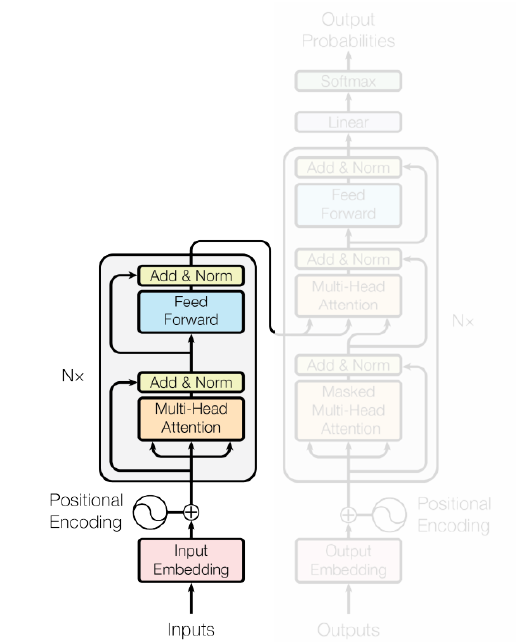

# 1. Positional embedding:

In [ ]:
# Positional embedding: This part of the code defines a new class called TokenAndPositionEmbedding, which is responsible for adding positional information to the token embeddings. 
class TokenAndPositionEmbedding(layers.Layer): # Define a new class TokenAndPositionEmbedding that inherits from the layers.Layer base class provided by Keras.
    def __init__(self, maxlen, vocab_size, embed_dim): # The constructor takes three parameters: 
        # maxlen (maximum length of input sequences), vocab_size (size of the vocabulary), and embed_dim (dimension of the embeddings).
        
        super(TokenAndPositionEmbedding, self).__init__()
        
        # Instantiate an embedding layer for tokens, with vocab_size input dimensions and embed_dim output dimensions. You can define your own custom embedding as well. 
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        
        # Instantiate another embedding layer for positional information with maxlen input dimensions and embed_dim output dimensions.
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x): #  It takes one argument, x (input tensor).
        maxlen = tf.shape(x)[-1] # Obtain the maximum sequence length by calling tf.shape(x)[-1].
        positions = tf.range(start=0, limit=maxlen, delta=1) # This range represents the positions of the tokens in the input sequence.
        positions = self.pos_emb(positions) # Obtain the positional embeddings by passing the positions through the position embedding layer (self.pos_emb)
        x = self.token_emb(x) # Obtain the token embeddings by passing the input tensor x through the token embedding layer (self.token_emb).
        return x + positions # Add the positional embeddings to the token embeddings, element-wise, and return the result.

        

# 2. MultiHead attention:
In this part of the code, we  define a custom layer for the transformer model called **MultiHeadSelfAttention**. This layer is responsible for implementing the multi-head self-attention mechanism, a key component in the transformer architecture.

In [ ]:
# defining the transformer layer
class MultiHeadSelfAttention(layers.Layer): # Define a new class MultiHeadSelfAttention that inherits from the layers.Layer base class provided by Keras
    def __init__(self, embed_dim, num_heads=8): # The constructor for the class takes two parameters, embed_dim and num_heads. 
        # embed_dim is the dimension of the input embeddings, and num_heads is the number of attention heads in the multi-head self-attention mechanism.
        
        #  super() is used to call the constructor of the base class, which is layers.Layer in this case. 
        # This is done to ensure that the initialization code for the base class is executed before the derived class's own initialization code.
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
            
        # projection_dim, is the dimension of each projected head in the multi-head self-attention mechanism
        self.projection_dim = embed_dim // num_heads
        # The projection_dim is used to divide the input embeddings into separate parts for each attention head. 
        # In the multi-head self-attention mechanism, the input embeddings are split into multiple smaller parts, 
        # allowing the model to focus on different aspects of the input and capture a variety of patterns. 
        
        # The followings are dense (fully connected) layers responsible for computing the query, key, and value matrices, respectively, from the input embeddings.
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        
        # Another dense layer that combines the outputs from all attention heads.
        self.combine_heads = layers.Dense(embed_dim)

    # This method calculates the attention scores, scales them, applies the softmax function to obtain the attention weights, 
    # and then computes the output by multiplying the attention weights with the value matrix.
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) # tf.cast is a TensorFlow function used to change the data type of a tensor. 
        # By using [-1], you are selecting the last element of the shape tensor. In this case, it corresponds to the dimension of the key vectors.
        
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights


    #This method is used to separate the different heads in the multi-head self-attention mechanism. 
    # It reshapes and transposes the input tensor according to the number of attention heads.
    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) # (batch_size, seq_length, self.num_heads, self.projection_dim)
        # By using -1, you're telling TensorFlow to compute the sequence length based on the input tensor's total number of elements, 
        # divided by the product of batch_size, self.num_heads, and self.projection_dim.
        return tf.transpose(x, perm=[0, 2, 1, 3]) #  The perm argument specifies the new order of the axes. (batch_size, self.num_heads, seq_length, self.projection_dim)
    
    
    # This method is the main entry point of the layer, and it is called when the layer is used in the model. 
    # It takes the input tensor, computes the query, key, and value matrices, separates the heads, 
    # calculates the attention and attention weights, combines the heads, and returns the final output.
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        # After the attention computation, the outputs from all heads are combined back into a single vector of the original embedding dimension.
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention) # dense layer that combines the outputs from all attention heads.
        return output


# 3. Transformer Block: 
This part of the code defines a new class called TransformerBlock, which represents a single transformer block (also known as a layer) in the transformer architecture. 
Each transformer block typically consists of a multi-head self-attention mechanism, followed by a position-wise feed-forward network (FFN), layer normalization, and dropout layers.

In [ ]:
# Define the Transformer block: 
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): # The constructor takes four parameters: 
        # embed_dim (dimension of input embeddings), num_heads (number of attention heads), ff_dim (dimension of the feed-forward network's hidden layer), and rate (dropout rate).
        
        super().__init__()
        
        # Instantiate the MultiHeadSelfAttention layer using the provided embed_dim and num_heads parameters.
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        
        # Define the position-wise feed-forward network (FFN) as a sequential model with two dense layers. 
        # The first dense layer has ff_dim units and a ReLU activation function, while the second dense layer has embed_dim units.
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        
        # Instantiate two layer normalization layers with an epsilon value of 1e-6 to stabilize the layer normalization process.
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Instantiate two dropout layers with the given dropout rate rate.
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)


    # This method is the main entry point of the layer, and it is called when the layer is used in the model. 
    # It takes two arguments: inputs (input tensor) and training (a boolean indicating whether the model is in training mode).
    def call(self, inputs, training):
        attn_output = self.att(inputs) #  Pass the input through the multi-head self-attention layer (self.att).
        attn_output = self.dropout1(attn_output, training=training) # Apply the first dropout layer (self.dropout1) to the attention output. Pre-norm (unlike the original set up)
        out1 = self.layernorm1(inputs + attn_output) # Add the attention output to the original input (residual connection) and apply the first layer normalization (self.layernorm1).
        ffn_output = self.ffn(out1) # pass the output through the feed-forward network (self.ffn).
        ffn_output = self.dropout2(ffn_output, training=training) # Apply the second dropout layer (self.dropout2) to the feed-forward network's output.
        return self.layernorm2(out1 + ffn_output) # Add the feed-forward network's output to the output from previous step (out1) (another residual connection) and apply the second layer normalization (self.layernorm2).


The TransformerBlock class represents a single transformer layer, and you can stack multiple instances of this class to create a deep transformer model for your text classification task.

# 4. Defining the Model

In [ ]:
# defining the model
def create_transformer_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim, num_blocks, num_classes, dropout_rate=0.1):
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(30, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
# download and prep the data
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


In [ ]:
x_train.shape

(25000, 600)

In [19]:
# train the model
vocab_size = 20000  # Only consider the top 20k words
maxlen = 600  # Only consider the first 600 words of each movie review
embed_dim = 32
num_heads = 2
ff_dim = 32
num_blocks = 2
num_classes = 2
dropout_rate = 0.1

model = create_transformer_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim, num_blocks, num_classes, dropout_rate)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


Epoch 1/10
782/782 [==============================] - 132s 158ms/step - loss: 0.3884 - accuracy: 0.8148 - val_loss: 0.2956 - val_accuracy: 0.8740
Epoch 2/10
782/782 [==============================] - 72s 92ms/step - loss: 0.1787 - accuracy: 0.9330 - val_loss: 0.3039 - val_accuracy: 0.8752
Epoch 3/10
782/782 [==============================] - 64s 82ms/step - loss: 0.0818 - accuracy: 0.9719 - val_loss: 0.4965 - val_accuracy: 0.8583
Epoch 4/10
782/782 [==============================] - 49s 62ms/step - loss: 0.0441 - accuracy: 0.9851 - val_loss: 0.5265 - val_accuracy: 0.8606
Epoch 5/10
782/782 [==============================] - 45s 58ms/step - loss: 0.0262 - accuracy: 0.9912 - val_loss: 0.5986 - val_accuracy: 0.8601
Epoch 6/10
782/782 [==============================] - 53s 67ms/step - loss: 0.0230 - accuracy: 0.9920 - val_loss: 0.6379 - val_accuracy: 0.8499
Epoch 7/10
782/782 [==============================] - 53s 68ms/step - loss: 0.0190 - accuracy: 0.9936 - val_loss: 0.7063 - val_accurac

# Links:
* Text classification with Transformers: https://keras.io/examples/nlp/text_classification_with_transformer/